# Przygotowania - pobieranie danych itp.

In [1]:
pip install googledrivedownloader

Note: you may need to restart the kernel to use updated packages.


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
path_dir = str(Path.home()) + "/data/2020/"  # ustawmy sciezke na HOME/data/2020
archive_dir = path_dir + "survey.zip"        # plik zapiszemy pod nazwa survey.zip

gdd.download_file_from_google_drive(
    file_id='1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB',
    dest_path=archive_dir,
    unzip=True
)

csv_path = 'file:////home/jovyan/data/2020/survey_results_public.csv'

In [3]:
from pyspark.sql import SparkSession

sparkSession = SparkSession \
.builder \
.config("spark.executor.instances", "1")\
.config('spark.driver.memory','1g')\
.config('spark.executor.memory', '1g') \
.getOrCreate()

df = sparkSession.read.csv(csv_path, inferSchema=True, header="true", nullValue='NA', nanValue='NA',emptyValue='NA')

# Punkt 2a)

In [4]:
a_result = df.select(df.EdLevel).distinct()
a_result.show(truncate = False)

a_result.count()

+----------------------------------------------------------------------------------+
|EdLevel                                                                           |
+----------------------------------------------------------------------------------+
|Primary/elementary school                                                         |
|null                                                                              |
|Other doctoral degree (Ph.D., Ed.D., etc.)                                        |
|I never completed any formal education                                            |
|Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                      |
|Associate degree (A.A., A.S., etc.)                                               |
|Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)|
|Professional degree (JD, MD, etc.)                                                |
|Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                 

10

### Odpowiedź: 10, ale jedna jest nullem

# Punkt 2b)

In [5]:
from pyspark.sql.functions import *
b_result = df.groupBy("Country").avg("WorkWeekHrs")
b_result.show(truncate=False)

+------------------------------------+------------------+
|Country                             |avg(WorkWeekHrs)  |
+------------------------------------+------------------+
|Senegal                             |34.285714285714285|
|Sweden                              |40.7496062992126  |
|Hong Kong (S.A.R.)                  |42.298507462686565|
|Republic of Korea                   |35.138888888888886|
|Philippines                         |37.32920792079208 |
|Singapore                           |40.25684931506849 |
|Turkey                              |43.77202643171806 |
|Iraq                                |49.07142857142857 |
|Germany                             |40.27298744460857 |
|Afghanistan                         |46.5              |
|Jordan                              |45.806451612903224|
|Sudan                               |36.714285714285715|
|France                              |40.38484399375975 |
|Greece                              |41.82364341085271 |
|Sri Lanka    

Aby pokazać wszystkie państwa, można użyć argumentu metody show, na przykład:  
b_result.show(b_result.count())  
pokaże wszystkie 184 wiersze.  

# Punkt 2c)

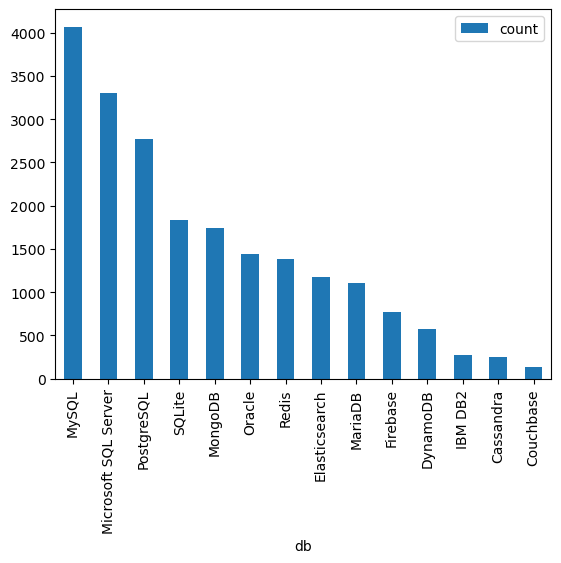

In [6]:
filtered = df \
.filter("YearsCodePro > 0 and DataBaseWorkedWith is not null and Hobbyist = false") \
.select("DatabaseWorkedWith")


splitted = filtered.select(
    split(filtered.DatabaseWorkedWith, ";")
    .alias("splitted")
)

single_dbs = splitted.select(
    posexplode(splitted.splitted)
) \
.drop("pos") \
.withColumnRenamed("col", "db")

counted = single_dbs.groupBy("db").count().sort(col("count").desc()).toPandas()
counted.plot.bar(x='db', y="count");

# Punkt 2d)

In [7]:
db_name = 'base'
table_name = 'survey'

In [8]:
sparkSession.sql(f'DROP DATABASE IF EXISTS {db_name} CASCADE')
sparkSession.sql(f'CREATE DATABASE {db_name}')
sparkSession.sql(f'USE {db_name}')

sparkSession.sql(f'DROP TABLE IF EXISTS {table_name}')
sparkSession.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{csv_path}"');

In [9]:
spark_df = sparkSession.sql(f'SELECT *, CAST((convertedComp > 60000) AS STRING) AS compAboveAvg \
                    FROM {table_name} where convertedComp IS NOT NULL ')

y = 'compAboveAvg'

### Wybrane zostały inne cechy niż w oryginalnym notatniku:

In [10]:
feature_columns = ['OpSys', 'EdLevel', 'MainBranch' , 'Country', 'YearsCode', 'Age1stCode', 'JobSeek', 'NEWLearn', 'NEWOvertime', 'YearsCodePro']
quantitative_columns = []

### Zbadany został stosunek liczności klas:

In [11]:
major_df = spark_df.filter(col(y) == True)
minor_df = spark_df.filter(col(y) == False)
ratio = major_df.count()/minor_df.count()
print("class ratio: {}".format(ratio))

class ratio: 0.8084187522763931


##### Stosunek wynosi około 4:5, więc klasy są całkiem dobrze zbalansowane.

In [12]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [13]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in feature_columns]
stringindexer_stages += [StringIndexer(inputCol=y, outputCol='label')]

onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in feature_columns]

extracted_columns = ['onehot_' + c for c in feature_columns]
extracted_columns += quantitative_columns
vectorassembler_stage = VectorAssembler(inputCols=extracted_columns, outputCol='features') 

### Próby użycia selekcji cech nie przyniosły rezultatów, model dawał lepsze wyniki przy ręcznej selekcji większej liczby atrybutów

In [14]:
#from pyspark.ml.feature import ChiSqSelector
#selector=ChiSqSelector(featuresCol="features", outputCol="selectedFeatures", labelCol= "label", numTopFeatures=10)

In [15]:
final_columns = extracted_columns + ['features', y, 'label']

In [16]:
pipelined_df = Pipeline(stages=stringindexer_stages + onehotencoder_stages + [vectorassembler_stage]).fit(spark_df).transform(spark_df)

training, test = pipelined_df.randomSplit([0.8, 0.2], seed=5)

# Trenowanie modelu:

### Wybrany został model Gradient-Boosted Trees (GBT), użyty został większy parametr maxIter oraz maxDepth

In [17]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter = 30, maxDepth=8)
model = gbt.fit(training)

In [18]:
prediction = model.transform(test)

label_and_pred = prediction.select('label', 'prediction')
label_and_pred.groupBy('label', 'prediction').count().toPandas()

,label,prediction,count
0,1.0,1.0,2495
1,0.0,1.0,500
2,1.0,0.0,580
3,0.0,0.0,3376


In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")

evaluator.evaluate(prediction)

0.9130518848532139

# Ostateczne wyniki naszego modelu:  
## Gradient Boosted Trees z inaczej dobranymi cechami i hiperparametrami
AUC = 0.9131  

Jest to wynik lepszy niż każdy z wcześniejszych modeli z notatnika ml.ipynb:  
0.6139 (dla DecisionTreeClassifier)  
0.6784 (dla DecisionTreeClassifier z walidacją krzyżową)  
0.8838 (dla GBT)  

Ustawianie większej wartości parametru maxIter powoduje wzrost metryki auROC kosztem dłuższego czasu trenowania.  
Dla maxIter > 30 czas trenowania jest już dość długi, a wzrost metryki minimalny.

Parametr maxDepth został ręcznie wybrany na wartość 8, prawdopodobnie przy większych wartościach dochodzi do przeuczenia.

In [20]:
sparkSession.stop()